# 4. 다중 언어 개체명 인식
## 4.1 데이터셋

In [1]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME 서브셋 개수: {len(xtreme_subsets)}")

XTREME 서브셋 개수: 183


In [2]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [3]:
from datasets import load_dataset

load_dataset('xtreme', name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [4]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# 키가 없는 경우 DatasetDict를 반환합니다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

In [5]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
              index=["Number of training exampels"])

,de,fr,it,en
Number of training exampels,12580,4580,1680,1180


In [6]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [7]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [10]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [11]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## 4.2 다중 언어 트랜스포머

## 4.3 XLM-R 토큰화

In [12]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [13]:
bert_tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [14]:
xlmr_tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [15]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [16]:
pd.DataFrame([bert_tokens, xlmr_tokens], ["BERT", "XLM-R"])

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### 4.3.1 토큰화 파이프라인

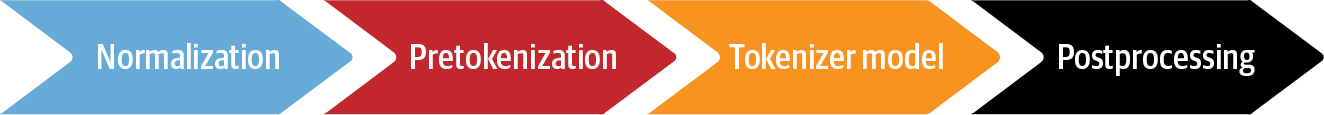

1. 정규화
- 유니코드 정규화 방식을 일반적으로 사용

2. 사전 토큰화
- 일반적으로 공백과 구두점을 기준 삼아 단어 분할
- 이후 BPE나 유니그램 알고리즘을 사용해 부분단어로 분할

3. 토크나이저 모델
- 단어를 부분단어로 나눠 어휘사전의 크기와 OOV 토큰의 개수를 줄이는 역할
- 부분단어 토큰화 알고리즘은 BPE, 유니그램, WordPiece 등이 있음

4. 사후 처리
- 예를 들어 시퀀스 처음과 끝에 특수 토큰을 추가하는 경우

### 4.3.2 SentencePiece 토크나이저
- 부분단어 분할 방식으로 유니그램을 사용
- 공백문자가 유니코드 기호 `U+2581` 또는 아래 1/4 블록 문자(lower one quarter block character)라고도 하는 _ 문자에 할당
- 따라서 정확하게 시퀀스를 복원

In [17]:
print("".join(xlmr_tokens))
print("".join(xlmr_tokens).replace(u"\u2581", " "))

<s>▁Jack▁Sparrow▁loves▁New▁York!</s>
<s> Jack Sparrow loves New York!</s>


In [18]:
# WordPiece의 경우 York와 ! 사이에 공백이 없다는 정보를 잃음
print(" ".join(bert_tokens))

[CLS] Jack Spa ##rrow loves New York ! [SEP]


## 4.4 개체명 인식을 위한 트랜스포머

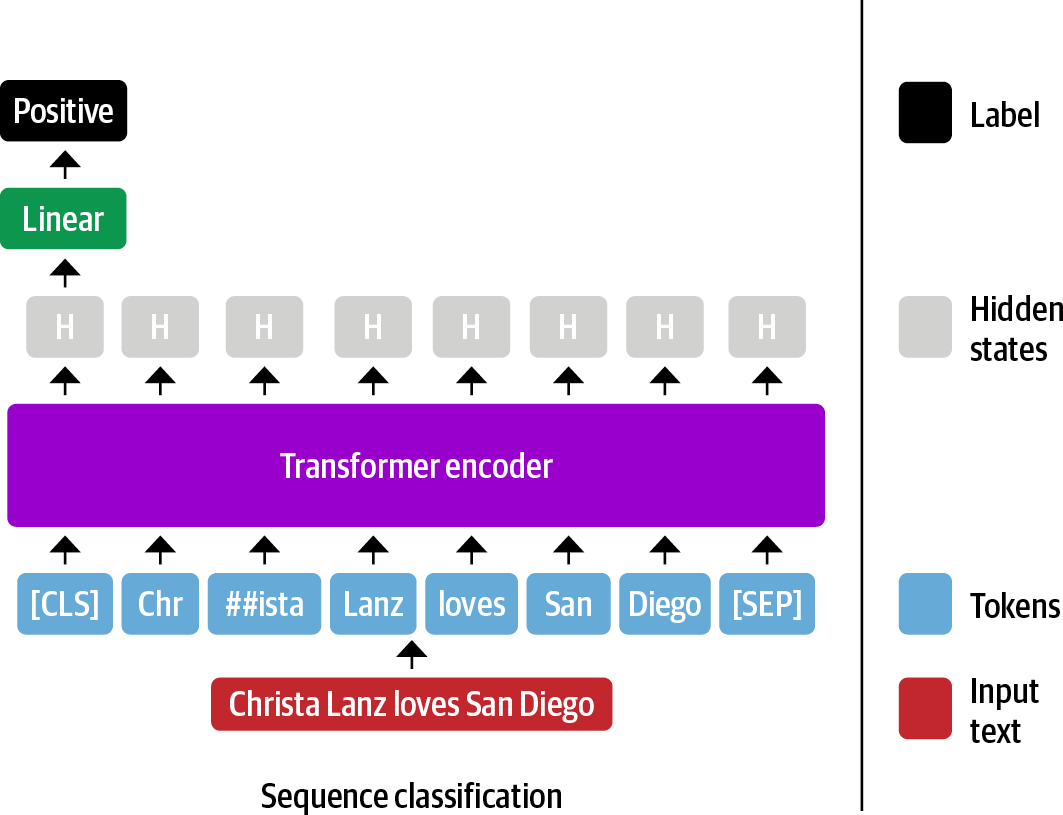

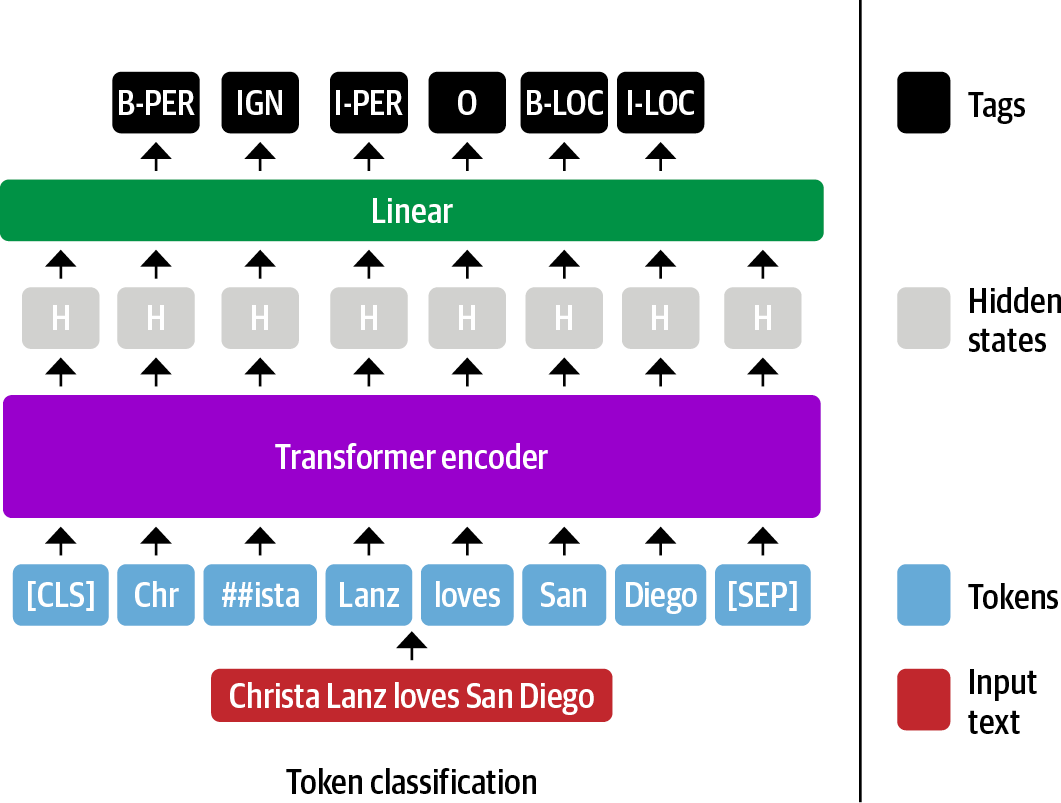

## 4.5 트랜스포머 모델 클래스
### 4.5.1 바디와 헤드
### 4.5.2 토큰 분류를 위한 사용자 정의 모델 만들기

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_calss = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 모델 바디를 로드합니다.
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # 토큰 분류 헤드를 준비합니다.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화합니다.
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask, 
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다.
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

### 4.5.3 사용자 정의 모델 로드하기

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'roberta.embeddings.position_ids',

In [23]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"시퀀스에 있는 토큰 개쉬: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개쉬: 10
출력 크기: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG


In [26]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 입력 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # 가능한 일곱 개의 클래스에 대한 로짓을 출력합니다.
    outputs = model(input_ids)[0]
    # argmax 함수로 토큰마다 가장 가능성이 높은 클래스를 선택합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[0] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## 4.6 NER 작업을 위해 텍스트 토큰화하기

`function(examples: Dict[str, List]) -> Dict[str, List]`

In [27]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [28]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [29]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [30]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [31]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [32]:
def encode_panx_dataset(corpus):
    return corpus.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=["langs", "ner_tags", "tokens"],
    )

In [33]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

## 4.7 성능 측정

In [34]:
from seqeval.metrics import classification_report

In [35]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [36]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    
    return preds_list, labels_list

## 4.8 XLM-RoBERTa 미세 튜닝하기

In [43]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
output_dir = f"D:/_MODEL_CHECKPOINT/{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=output_dir,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    # save_steps= 1e6,
    save_strategy="epoch",
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps
)

In [44]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [45]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [46]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [47]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [48]:
trainer.train()

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1575 [00:00<?, ?it/s]

{'loss': 0.2582, 'learning_rate': 3.3365079365079365e-05, 'epoch': 1.0}


  0%|          | 0/263 [00:00<?, ?it/s]

{'eval_loss': 0.16072675585746765, 'eval_f1': 0.8248471341219498, 'eval_runtime': 9.3031, 'eval_samples_per_second': 676.119, 'eval_steps_per_second': 28.27, 'epoch': 1.0}
{'loss': 0.1298, 'learning_rate': 1.673015873015873e-05, 'epoch': 2.0}


  0%|          | 0/263 [00:00<?, ?it/s]

{'eval_loss': 0.13927651941776276, 'eval_f1': 0.848512585812357, 'eval_runtime': 9.4929, 'eval_samples_per_second': 662.601, 'eval_steps_per_second': 27.705, 'epoch': 2.0}
{'loss': 0.0813, 'learning_rate': 9.523809523809524e-08, 'epoch': 2.99}


  0%|          | 0/263 [00:00<?, ?it/s]

{'eval_loss': 0.1387612372636795, 'eval_f1': 0.8613686785368906, 'eval_runtime': 9.1127, 'eval_samples_per_second': 690.249, 'eval_steps_per_second': 28.861, 'epoch': 3.0}
{'train_runtime': 848.5659, 'train_samples_per_second': 44.475, 'train_steps_per_second': 1.856, 'train_loss': 0.15634005463312542, 'epoch': 3.0}


TrainOutput(global_step=1575, training_loss=0.15634005463312542, metrics={'train_runtime': 848.5659, 'train_samples_per_second': 44.475, 'train_steps_per_second': 1.856, 'train_loss': 0.15634005463312542, 'epoch': 3.0})

## 4.9 오류 분석

In [51]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환합니다.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # 데이터를 모델에 전달합니다.
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택합니다.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산합니다.
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # 배치 차원을 다시 만들고 넘파이 배열로 변환합니다.
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss": loss, "predicted_label": predicted_label}

In [52]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [54]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.009595581, 0.0, 0.030204495, 0.0142560...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [56]:
df_tokens = df.apply(pd.Series.explode)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,0,1,IGN,0.0,I-ORG,<s>
0,10699,1,B-ORG,0.009596,B-ORG,▁Ham
0,11,1,IGN,0.0,I-ORG,a
0,15,1,I-ORG,0.030204,I-ORG,▁(
0,16104,1,I-ORG,0.014256,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.019819,I-ORG,▁)
0,2,1,IGN,0.0,O,</s>


In [60]:
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.03,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.24,B-ORG,▁Luz
1,10,1,I-ORG,0.07,I-ORG,▁a


In [58]:
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.03,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.24,B-ORG,▁Luz
1,10,1,I-ORG,0.07,I-ORG,▁a


In [61]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼을 삭제합니다.
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁/,▁(,▁),▁'',▁A
count,6066,989,1388,808,1171,163,246,246,2898,125
mean,0.04,0.13,0.09,0.14,0.08,0.47,0.29,0.27,0.02,0.43
sum,213.58,133.02,127.13,114.95,96.61,77.38,71.39,67.63,66.69,53.22


In [62]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.63,0.62,0.51,0.34,0.26,0.18,0.03
sum,1702.78,904.13,1957.78,1071.63,748.54,762.16,1373.46


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


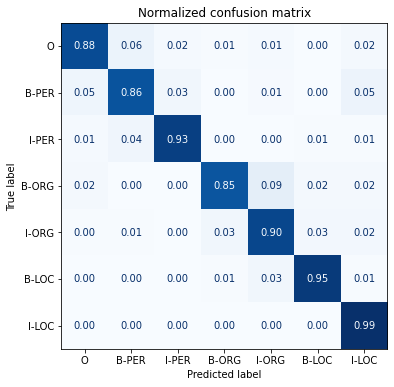

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [75]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, maks in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp


df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.21,0.00,0.00,8.65,9.48,9.47,7.36,0.00,8.96,9.59,8.90,7.97,4.80,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,B-ORG,O,O,I-ORG,O,O,O,O,O,O,B-ORG
losses,0.00,0.00,5.87,0.00,0.00,0.00,10.60,9.71,8.64,4.98,5.39,0.00,5.94,6.73,0.00,8.07,7.09,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.23,4.88,5.16,0.00,5.44,0.00,5.23,0.00,4.68,5.59,5.89,5.33,5.19,4.97,0.00


In [77]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,0.01,0.00,0.03,0.01,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


## 4.10 교차 언어 전이

In [78]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [80]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")

  0%|          | 0/263 [00:00<?, ?it/s]

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.865


In [82]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,O,O,O,O,O,O,O,O,O,O,O,O,O


In [83]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

  0%|          | 0/96 [00:00<?, ?it/s]

[fr] 데이터셋에서 [de] 모델의 F1-점수: 0.702


In [84]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[it] 데이터셋에서 [de] 모델의 F1-점수: 0.646


In [85]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[en] 데이터셋에서 [de] 모델의 F1-점수: 0.580


### 4.10.1 제로샷 전이가 유용할 때

In [86]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
                      data_collator=data_collator, compute_metrics=compute_metrics,
                      train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [87]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [88]:
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/33 [00:00<?, ?it/s]

{'loss': 1.7655, 'learning_rate': 3.484848484848485e-05, 'epoch': 0.91}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.2964402437210083, 'eval_f1': 0.09848068826652022, 'eval_runtime': 45.2573, 'eval_samples_per_second': 50.6, 'eval_steps_per_second': 2.121, 'epoch': 1.0}
{'loss': 1.2602, 'learning_rate': 1.9696969696969697e-05, 'epoch': 1.82}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.1464072465896606, 'eval_f1': 0.1708253358925144, 'eval_runtime': 46.9465, 'eval_samples_per_second': 48.779, 'eval_steps_per_second': 2.045, 'epoch': 2.0}
{'loss': 1.1066, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.73}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.066677212715149, 'eval_f1': 0.17123185151923365, 'eval_runtime': 43.5235, 'eval_samples_per_second': 52.615, 'eval_steps_per_second': 2.206, 'epoch': 3.0}
{'train_runtime': 340.486, 'train_samples_per_second': 2.203, 'train_steps_per_second': 0.097, 'train_loss': 1.3456701509880298, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

,num_samples,f1_score
0,250,0.15806


In [89]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

{'loss': 1.5218, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.0421239137649536, 'eval_f1': 0.20852803738317754, 'eval_runtime': 52.305, 'eval_samples_per_second': 43.782, 'eval_steps_per_second': 1.835, 'epoch': 1.0}
{'loss': 0.9152, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.7162318229675293, 'eval_f1': 0.5463806142923291, 'eval_runtime': 51.7891, 'eval_samples_per_second': 44.218, 'eval_steps_per_second': 1.854, 'epoch': 2.0}
{'loss': 0.6142, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.592078447341919, 'eval_f1': 0.6072153677963454, 'eval_runtime': 47.428, 'eval_samples_per_second': 48.284, 'eval_steps_per_second': 2.024, 'epoch': 3.0}
{'train_runtime': 508.8654, 'train_samples_per_second': 2.948, 'train_steps_per_second': 0.124, 'train_loss': 0.9979907936520047, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\Kang MinJae\AppData\Local\Temp\ipykernel_31664\334256818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/126 [00:00<?, ?it/s]

{'loss': 1.2089, 'learning_rate': 3.3730158730158734e-05, 'epoch': 0.98}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.6428994536399841, 'eval_f1': 0.5902097902097903, 'eval_runtime': 22.1263, 'eval_samples_per_second': 103.497, 'eval_steps_per_second': 4.339, 'epoch': 1.0}
{'loss': 0.5061, 'learning_rate': 1.746031746031746e-05, 'epoch': 1.95}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4059099555015564, 'eval_f1': 0.7462929770246048, 'eval_runtime': 22.2772, 'eval_samples_per_second': 102.796, 'eval_steps_per_second': 4.309, 'epoch': 2.0}
{'loss': 0.3296, 'learning_rate': 1.1904761904761904e-06, 'epoch': 2.93}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.37897518277168274, 'eval_f1': 0.7625308134757601, 'eval_runtime': 22.8128, 'eval_samples_per_second': 100.382, 'eval_steps_per_second': 4.208, 'epoch': 3.0}
{'train_runtime': 655.6793, 'train_samples_per_second': 4.575, 'train_steps_per_second': 0.192, 'train_loss': 0.671666947149095, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\Kang MinJae\AppData\Local\Temp\ipykernel_31664\334256818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.824, 'learning_rate': 3.353174603174603e-05, 'epoch': 0.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4778040945529938, 'eval_f1': 0.6607142857142857, 'eval_runtime': 27.6352, 'eval_samples_per_second': 82.865, 'eval_steps_per_second': 3.474, 'epoch': 1.0}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 for num_samples in [500, 1000, 2000, 4000]:                                                  │
│   2 │   metrics_df = metrics_df.append(                                                          │
│ ❱ 3 │   │   train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)                    │
│   4                                                                                              │
│                                                                                                  │
│ in train_on_subset:10                                                                            │
│                                                                                                  │
│    7 │   trainer = Trainer(model_init=model_init, args=training_args,                            │
│    8 │   │   │   │   │     data_collator=data_collator, compute_metrics=compute_metrics,         │
│    9 │   │   │   │   │     train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_toke    │
│ ❱ 10 │   trainer.train()                                                                         │
│   11 │                                                                                           │
│   12 │   f1_score = get_f1_score(trainer, test_ds)                                               │
│   13 │   return pd.DataFrame.from_dict(                                                          │
│                                                                                                  │
│ c:\Users\Kang                                                                                    │
│ MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\trainer.py:1664 in │
│ train                                                                                            │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ c:\Users\Kang                                                                                    │
│ MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\trainer.py:1940 in │
│ _inner_training_loop                                                                             │
│                                                                                                  │
│   1937 │   │   │   │   │   with model.no_sync():                                                 │
│   1938 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1939 │   │   │   │   else:                                                                     │
│ ❱ 1940 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1941 │   │   │   │                                                                             │
│   1942 │   │   │   │   if (                                

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### 4.10.2 다국어에서 동시에 미세 튜닝하기

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

panx_de_fr_encoded = concatenate_datasets([panx_de_encoded, panx_fr_encoded])

In [ ]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.output_dir = f"D:/_MODEL_CHECKPOINT/{xlmr_model_name}-finetuned-panx-de-fr"

trainier = Trainer(model_init=model_init, args=training_args,
                   data_collator=data_collator, compute_metrics=compute_metrics,
                   tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                   eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()

In [ ]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

In [ ]:
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외합니다.
for lang in langs[1:]:
    training_args.output_dir =  f"D:/_MODEL_CHECKPOINT/{xlmr_model_name}-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝합니다.
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 F1-점수를 모읍니다.
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가합니다.
    corpora.append(ds_encoded)

In [ ]:
corpora_encoded = concatenate_datasets(corpora)

In [ ]:
training_ar